# Disclaimer

This notebook has an information purpose and doesn't constitute any type of trading or investment advice. No one will responsible for any damages caused by using data,information,methods,models,algorithms,opinios or conclusions for trading or investment decisions.

# Portfolio Optimization

Portfolio optimization is the process of selecting the best portfolio (asset distribution), out of the set of all portfolios being considered, according to some objective. The objective typically maximizes factors such as expected return, and minimizes costs like financial risk. This notebook, I will introduce 2 methods for Asset Allocation: Monte Carlo Simulation and Mathematical Optimization

## Assumptions

No Transaction Cost, Risk Free Rate=0

##  Import Libraries

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

In [183]:
df=pd.read_csv('D:/Download/Total.csv',index_col='Date')

In [184]:
df.head()

,0005,0992,1299,0027
Date,,,,
1/3/2017,59.903236,4.530504,43.060986,33.349998
1/4/2017,60.331112,4.634545,42.864136,33.349998
1/5/2017,60.758999,4.710211,43.749966,34.200001
1/6/2017,60.616367,4.691295,44.094452,34.000000
1/9/2017,60.568825,4.748044,44.635788,35.450001


* 0005:HSBC Holdings plc
* 0992:Lenovo Group Limited
* 1299:AIA Group Limited (1299.HK)
* 0027:Galaxy Entertainment Group Limited

Using Adjusetd close price for calculation

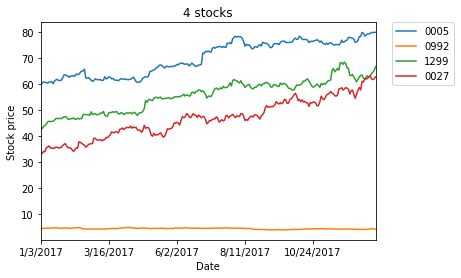

In [185]:
df.plot()
plt.ylabel('Stock price')
plt.title('4 stocks')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Log Returns

We will now switch over to using log returns instead of arithmetic returns, for many of our use cases they are almost the same,but most technical analyses require detrending/normalizing the time series and using log returns is a nice way to do that. Log returns are convenient to work with in many of the algorithms we will encounter.

In [186]:
log_return=np.log(df/df.shift(1))

In [187]:
log_return.head()

,0005,0992,1299,0027
Date,,,,
1/3/2017,NaN,NaN,NaN,NaN
1/4/2017,0.007117,0.022705,-0.004582,0.000000
1/5/2017,0.007067,0.016195,0.020455,0.025168
1/6/2017,-0.002350,-0.004024,0.007843,-0.005865
1/9/2017,-0.000785,0.012024,0.012202,0.041763


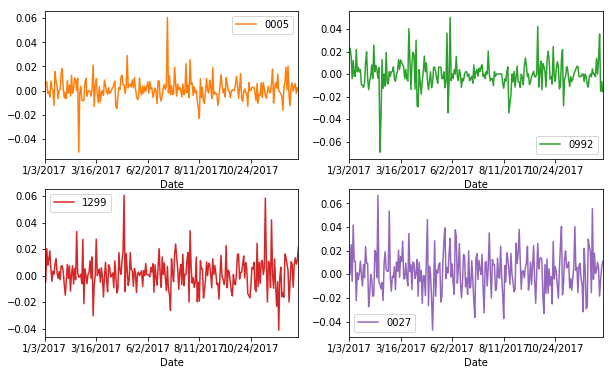

In [188]:
for i,j,k in zip(log_return.columns,[1,2,3,4],['C1','C2','C3','C4']):
    plt.subplot(2,2,j)
    log_return[i].plot(figsize=(10,6),color=k)
    plt.legend()
    plt.xlabel('Date')

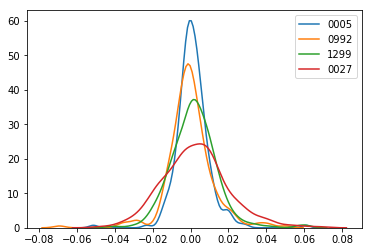

In [189]:
for i in range(4):
    sns.kdeplot(log_return[log_return.columns[i]].dropna())

Log return follow normal distribution

In [190]:
log_return.mean() * len(log_return)

0005    0.287257
0992   -0.027068
1299    0.438613
0027    0.633870
dtype: float64

log return * business day

In [191]:
log_return.cov() * len(log_return)

,0005,0992,1299,0027
0005,0.020349,0.004421,0.007478,0.008130
0992,0.004421,0.037900,0.002197,0.009536
1299,0.007478,0.002197,0.037784,0.010189
0027,0.008130,0.009536,0.010189,0.073927


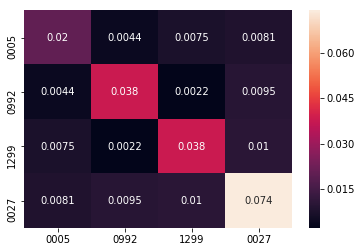

In [192]:
sns.heatmap(log_return.cov() * len(log_return),annot=True)

## Monte Carlo Simulation for Asset Allocation

In [193]:
np.random.seed(101)
num_of_ite = 50000
all_weights = np.zeros((num_of_ite,len(df.columns)))
port_return = np.zeros(num_of_ite)
port_vol = np.zeros(num_of_ite)
sharpe_ratio = np.zeros(num_of_ite)

for i in range(num_of_ite):
    weights = np.array(np.random.random(4))
    weights = weights / np.sum(weights)
    all_weights[i,:] = weights
    port_return[i] = np.sum((log_return.mean() * weights) *len(log_return))
    port_vol[i] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * len(log_return), weights)))
    sharpe_ratio[i] = port_return[i]/port_vol[i]

In order to calculate portfolio return and volatility, we need to multiply by number of business day in 2017, which is len(log_return)

In [194]:
sharpe_ratio.max()

3.1853079267750815

In [195]:
sharpe_ratio.argmax()

46225

In [197]:
all_weights[46225,:]

array([ 0.37262437,  0.00062034,  0.33797863,  0.28877666])

These 4 numbers mean the 'best' weighting for portfolio

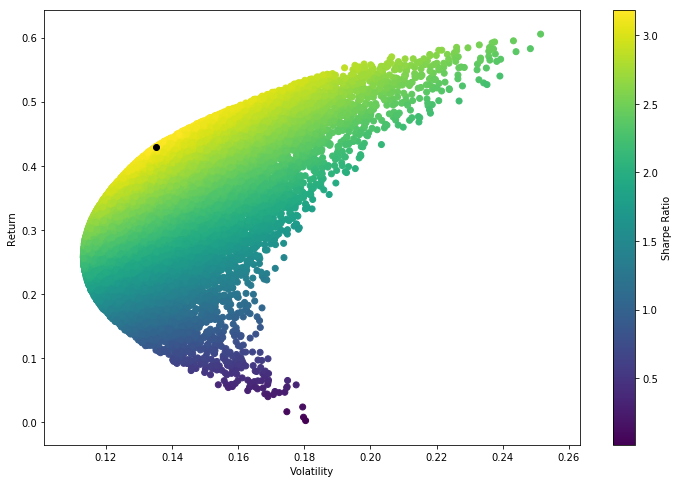

In [198]:
max_port_return = port_return[46225]
max_port_vol = port_vol[46225]

plt.figure(figsize=(12,8))
plt.scatter(x=port_vol,y=port_return,c=sharpe_ratio)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.scatter(x=max_sr_vol,y=max_sr_ret,c='black')

## Mathematical Optimization for Asset Allocation

Other than Monte Carlo Simulation, there is other method for asset allocation, Mathematical Optimization

In [199]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * len(log_return)
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * len(log_return), weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

Optimization works as a minimization function, since we actually want to maximize the Sharpe Ratio, we will need to turn it negative so we can minimize the negative sharpe (same as maximizing the postive sharpe)

In [200]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [201]:
def check_sum(weights):
    return np.sum(weights) - 1

In [205]:
cons = ({'type':'eq','fun': check_sum})
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
init_guess = [0.25,0.25,0.25,0.25]
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [206]:
opt_results

     fun: -3.1868224730919286
     jac: array([  1.26081705e-03,   1.05371025e+00,   9.71555710e-04,
        -2.87204981e-03])
 message: 'Optimization terminated successfully.'
    nfev: 39
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 0.36707454,  0.        ,  0.35208831,  0.28083716])

In [208]:
opt_results.x

array([ 0.36707454,  0.        ,  0.35208831,  0.28083716])

These 4 numbers mean the 'best' weighting for portfolio

In [207]:
get_ret_vol_sr(opt_results.x)

array([ 0.43788964,  0.13740635,  3.18682247])

If using the above weighting for investment, it will get the below number
* 0.4378 is portfolio expected return
* 0.1374 is portfolio volatility
* 3.1868 is sharpe ratio

## Conclusion

Both Monte Calro Simulation and Mathematical Optimization are work for Asset Allocation, Weighting factor from simulation is similar to Optimization

Weighting for stock '0092' is very small, almost neglectable

Transaction cost will significantly affect the sharpe ratios. In particular, transaction cost need to consider for investment